## Import modules

In [1]:
from System.paths import *
from OMM_interface.openmm import *
import os, re
import numpy as np
from pathlib import Path
from ASE_interface.ase_calculation import CP2K
from Coord_Toolz.mdanalysis import MDA_reader
from Direct_cp2k_calculation.direct_cp2k import Direct_Calculator
from System.paths import Paths
from System.system import *
from ASE_interface.ase_calculation import ASE_system
from Parametrization.parametrization import Parametrization
from Parametrization.optimizers import Optimizer
from Coord_Toolz.mdanalysis import *
from OMM_interface.openmm import OpenMM_system

## Configure Paths

In [2]:
system_name = 'mp1'

In [3]:
paths = Paths()

paths.working_dir = '/home/ac127777/Documents/TheForceOutput/'+system_name
paths.project_name = system_name

paths.mm_top_file = 'smallbox.psf'
paths.mm_top_file_path = '/home/ac127777/Documents/phosphate_parametrization/cp2k_geom_opts/'+system_name
paths.mm_crd_file = 'structure_0.pdb'
paths.mm_crd_file_path = paths.mm_top_file_path
paths.mm_str_file = 'mp1.str'
paths.mm_str_file_path = '/home/ac127777/Documents/phosphate_parametrization/cp2k_geom_opts/'+system_name
paths.mm_traj_file = 'smallbox.dcd'
paths.mm_traj_file_path = '/home/ac127777/Documents/phosphate_parametrization/cp2k_geom_opts/'+system_name

paths.set()

## Import Molecules:

Set up System.system.Molecular_system

In [4]:
Molsys = Molecular_system('net_properties', 'forces')

In [5]:
Molsys.paths = paths

Set up Coord_Toolz.mdanalysis.MDA_reader object for both molecules dissolved, one molecule dissolved, and the other molecule dissolved

In [6]:
MDR = MDA_reader()
MDR.set_traj_input(paths.mm_crd, paths.mm_traj)

/home/ac127777/anaconda3/envs/mdanalysis-dev/lib/python3.8/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [7]:
MDR.universes['nosol'] = MDR.delete_one_molecule('not resname TIP3') #mp1

export nosol

In [8]:
write_single_pdb(MDR.universes['nosol'], 'nosol.pdb', paths.working_dir)

/home/ac127777/anaconda3/envs/mdanalysis-dev/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


export mol1 and mol2

...externally generate topology files for mol1 and mol2....
e.g. run 'charmm -i genpsf.inp -o genpsf.out'

add paths to coordinate and topology files

In [9]:
paths.working_dir

'/home/ac127777/Documents/TheForceOutput/mp1/'

In [10]:
paths.mm_nosol_crd_file_path = paths.working_dir
paths.mm_nosol_crd_file = 'nosol.pdb'

paths.mm_nosol_top_file_path = paths.working_dir
paths.mm_nosol_top_file = 'nosol.psf'

paths.set()

In [11]:
paths.mm_nosol_crd_file_path

'/home/ac127777/Documents/TheForceOutput/mp1/'

check if they work

In [12]:
for filepath in [paths.mm_nosol_crd, paths.mm_nosol_top]:
    check_if_file_exists(filepath)

Fill Molecular_system storage

In [13]:
Molsys.set_ini_coords(MDR)

## Run QM scheme

### option 1.1: no charge calc, no optimization

define cp2k_inp

Run the DFT calculation

### option 1.2: no charge calc, geometry optimization

define cp2k_inp

Run the DFT calculation

use the new optimized coords and run a single-point calculation:

generate a new MDA_reader object

exchange the ini_coords for the opt_coords

Run the DFT calculation

### option 2.1: calculate charges, energies, forces, no geom opt

define cp2k_inp

In [14]:
cp2k_inp2 = """  
&FORCE_EVAL
  METHOD Quickstep              ! Electronic structure method (DFT,...)
  &DFT
    BASIS_SET_FILE_NAME  BASIS_MOLOPT_UZH
    POTENTIAL_FILE_NAME  POTENTIAL_UZH
    CHARGE 0
    &MGRID
      NGRIDS 5
      CUTOFF 550
      REL_CUTOFF 80
    &END MGRID
    &QS
      METHOD GPW
      EPS_DEFAULT 1.0E-12
    &END QS
    &POISSON                    ! Solver requested for non periodic calculations
      PERIODIC XYZ
      PSOLVER  PERIODIC          ! Type of solver
    &END POISSON
    &SCF                        ! Parameters controlling the convergence of the scf. This section should not be changed. 
      SCF_GUESS ATOMIC
      EPS_SCF 1.0E-5
      MAX_SCF 800
      &MIXING
        ALPHA 0.4
      &END MIXING
      &OT
        MINIMIZER CG
      &END OT
    &END SCF
    &XC                        ! Parameters needed to compute the electronic exchange potential 
      &VDW_POTENTIAL
        DISPERSION_FUNCTIONAL PAIR_POTENTIAL
        &PAIR_POTENTIAL
          TYPE DFTD3
          PARAMETER_FILE_NAME  dftd3.dat
          REFERENCE_FUNCTIONAL PBE
          CALCULATE_C9_TERM TRUE
          REFERENCE_C9_TERM TRUE
        &END PAIR_POTENTIAL
      &END VDW_POTENTIAL
      &XC_FUNCTIONAL PBE
      &END XC_FUNCTIONAL
    &END XC
  &END DFT

  &SUBSYS
    &KIND H
      ELEMENT H
      BASIS_SET TZV2P-MOLOPT-PBE-GTH-q1
      POTENTIAL GTH-PBE-q1
    &END KIND
    &KIND C
      ELEMENT C
      BASIS_SET TZV2P-MOLOPT-PBE-GTH-q4
      POTENTIAL GTH-PBE-q4
    &END KIND
    &KIND P
      ELEMENT P
      BASIS_SET TZV2P-MOLOPT-PBE-GTH-q5
      POTENTIAL GTH-PBE-q5
    &END KIND
    &KIND O
      ELEMENT O
      BASIS_SET TZV2P-MOLOPT-PBE-GTH-q6
      POTENTIAL GTH-PBE-q6
    &END KIND
    &KIND NA
      ELEMENT Na
      BASIS_SET TZV2P-MOLOPT-PBE-GTH-q9
      POTENTIAL GTH-PBE-q9
    &END KIND
    &KIND N
      ELEMENT N
      BASIS_SET TZV2P-MOLOPT-PBE-GTH-q5
      POTENTIAL GTH-PBE-q5
    &END KIND
    &PRINT
      &ATOMIC_COORDINATES LOW
      &END ATOMIC_COORDINATES
      &INTERATOMIC_DISTANCES LOW
      &END INTERATOMIC_DISTANCES
      &KINDS 
        POTENTIAL
      &END KINDS
      &TOPOLOGY_INFO
        PSF_INFO
      &END TOPOLOGY_INFO
    &END PRINT
  &END SUBSYS

  &PROPERTIES
    &RESP
      &SPHERE_SAMPLING
            AUTO_VDW_RADII_TABLE CAMBRIDGE
            AUTO_RMIN_SCALE 1.0
            AUTO_RMAX_SCALE 3.0
      &END
      &PRINT
        &COORD_FIT_POINTS
        &END
        &V_RESP_CUBE
        &END
      &END
    &END RESP
  &END PROPERTIES

  &PRINT
    &FORCES ON
    &END FORCES
  &END PRINT

&END FORCE_EVAL """

Run the DFT calculation

### option 2.2: calculate charges, energies, forces, and optimize geometry

define cp2k_inp

Run DFT calc

use the new optimized coords and run a single-point calculation:

generate a new MDA_reader object

exchange the ini_coords for the opt_coords

Run the DFT calculation

### option 3.1: read in data from external cluster calcs

use the new optimized coords and run a single-point calculation:

generate a new MDA_reader object

exchange the ini_coords for the opt_coords

Run the DFT calculation

### option 3.2: read in all data from external cluster calcs

In [15]:
Molsys.read_qm_charges_energies_forces_optcoords('all', paths.mm_top_file_path, 'mp1'+'_opt', 'geom_opt', 'RESP') #mp1

reading qm frame 0 info


/home/ac127777/anaconda3/envs/mdanalysis-dev/lib/python3.8/site-packages/MDAnalysis/analysis/base.py:438: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time


reading qm frame 1 info
reading qm frame 2 info


reading qm frame 3 info
reading qm frame 4 info
reading qm frame 5 info
reading qm frame 6 info
reading qm frame 7 info
reading qm frame 8 info
reading qm frame 9 info
reading qm frame 10 info
reading qm frame 11 info
reading qm frame 12 info
reading qm frame 13 info
reading qm frame 14 info
reading qm frame 15 info
reading qm frame 16 info
reading qm frame 17 info
reading qm frame 18 info
reading qm frame 19 info
reading qm frame 20 info
reading qm frame 21 info
reading qm frame 22 info
reading qm frame 23 info
reading qm frame 24 info
reading qm frame 25 info
reading qm frame 26 info
reading qm frame 27 info
reading qm frame 28 info
reading qm frame 29 info
reading qm frame 30 info
reading qm frame 31 info
reading qm frame 32 info
reading qm frame 33 info
reading qm frame 34 info
reading qm frame 35 info
reading qm frame 36 info
reading qm frame 37 info
reading qm frame 38 info
reading qm frame 39 info
reading qm frame 40 info
reading qm frame 41 info
reading qm frame 42 info
reading

In [16]:
Molsys.read_qm_energies_forces('nosol', paths.mm_nosol_crd_file_path+'/mp1', 'cp2k', 'nosol', 'ase') #mp1

generate a new MDA_reader object

In [17]:
MDR_optcoords = MDA_reader()

load the opt_coords

In [18]:
MDR_optcoords.universes['all'] = merge_atoms_positions(Molsys.opt_coords['all'], MDR.universes['all'].atoms)

In [19]:
MDR_optcoords.universes['nosol'] = MDR_optcoords.delete_one_molecule('not resname TIP3') #mp1

optional but recommended: Set ini_coords to optcoords

In [20]:
Molsys.set_ini_coords(MDR_optcoords) 

### calculate QM net forces

In [21]:
Molsys.calculate_qm_net_forces()

## Run MM scheme

Set up OpenMM system(s) and link them to Molecular_system

first do entire system

In [22]:
omm_sys_all = OpenMM_system(topology_format='CHARMM', top_file=paths.mm_top, crd_format='PDB',
                        crd_file=paths.mm_crd, charmm_param_file=paths.mm_stream, pbc=True,
                        cell=[1.6, 1.6, 1.6], angles=[90, 90, 90])

In [23]:
omm_sys_all.create_system_params['nonbondedCutoff'] = 0.8 * unit.nanometer
omm_sys_all.create_system_params['constraints'] = app.HBonds
omm_sys_all.import_molecular_system()

/home/ac127777/Documents/TheForce/OMM_interface
/home/ac127777/Documents/TheForce/OMM_interface/top_all36_cgenff.rtf


In [24]:
omm_sys_all.set_integrator()


In [25]:
omm_sys_all.set_platform()
omm_sys_all.create_openmm_system()

In [26]:
omm_sys_all.set_openmm_context()

Number of constraints: 228
constraints settings: HBonds
make sure these are correct before setting context


In [27]:
Molsys.openmm_systems['all'] = omm_sys_all

then for molecule 1 

...and molecule 2

...or the molecule without solvent

In [28]:
omm_sys_nosol = OpenMM_system(topology_format='CHARMM', top_file=paths.mm_nosol_top, crd_format='PDB',
                        crd_file=paths.mm_nosol_crd, charmm_param_file=paths.mm_stream, pbc=True,
                        cell=[1.6, 1.6, 1.6], angles=[90, 90, 90])

In [29]:
omm_sys_nosol.create_system_params['nonbondedCutoff'] = 0.8 * unit.nanometer
omm_sys_nosol.create_system_params['constraints'] = app.HBonds
omm_sys_nosol.import_molecular_system()
omm_sys_nosol.set_integrator()
omm_sys_nosol.set_platform()
omm_sys_nosol.create_openmm_system()
omm_sys_nosol.set_openmm_context()

/home/ac127777/Documents/TheForce/OMM_interface
/home/ac127777/Documents/TheForce/OMM_interface/top_all36_cgenff.rtf
Number of constraints: 4
constraints settings: HBonds
make sure these are correct before setting context


In [30]:
Molsys.openmm_systems['nosol'] = omm_sys_nosol

### ...now extract the force field... 

In [31]:
for omm_system_name in Molsys.openmm_systems.keys():
    if Molsys.openmm_systems[omm_system_name] != None:
        Molsys.openmm_systems[omm_system_name].extract_forcefield()

In [32]:
for omm_system_name in Molsys.openmm_systems.keys():
    if Molsys.openmm_systems[omm_system_name] != None:
        Molsys.openmm_systems[omm_system_name].create_force_field_optimizable(opt_charges=True, opt_lj=True)

In [33]:
for omm_system_name in Molsys.openmm_systems.keys():
    if Molsys.openmm_systems[omm_system_name] != None:
        Molsys.get_mm_charges(omm_system_name)

### ...calculate the classical forces...

In [34]:
for omm_system_name in Molsys.openmm_systems.keys():
    if Molsys.openmm_systems[omm_system_name] != None:
        Molsys.generate_mm_energies_forces(omm_system_name)

########################################
# calculated MM F&E of 50 frames
########################################
########################################
# calculated MM F&E of 50 frames
########################################


In [35]:
### start debugging ###

In [36]:
omm_sys_all.create_system_params

{'nonbondedMethod': PME,
 'nonbondedCutoff': Quantity(value=0.8, unit=nanometer),
 'switchDistance': Quantity(value=0.7, unit=nanometer),
 'constraints': HBonds,
 'rigidWater': False,
 'temperature': Quantity(value=310.0, unit=kelvin)}

In [37]:
vars(omm_sys_all.crd)

{'topology': <Topology; 1 chains, 114 residues, 347 atoms, 224 bonds>,
 '_positions': [Quantity(value=[Vec3(x=0.6899000000000001, y=0.45270000000000005, z=0.9046), Vec3(x=0.6803, y=0.5787, z=0.8390000000000001), Vec3(x=0.8131, y=0.6726000000000001, z=0.8251), Vec3(x=0.8472, y=0.7358, z=0.9707000000000001), Vec3(x=0.7759, y=0.798, z=0.7412000000000001), Vec3(x=0.9278000000000001, y=0.5847000000000001, z=0.7823000000000001), Vec3(x=0.6029, y=0.4328000000000001, z=0.9707000000000001), Vec3(x=0.7829, y=0.44450000000000006, z=0.9649), Vec3(x=0.7063, y=0.3792, z=0.8230000000000001), Vec3(x=0.7682000000000001, y=0.7210000000000001, z=1.0233), Vec3(x=0.806, y=1.0227000000000002, z=0.7249), Vec3(x=0.15410000000000001, y=1.0802, z=1.5649), Vec3(x=0.126, y=1.1631, z=1.5262000000000002), Vec3(x=0.17820000000000003, y=1.0257, z=1.4899), Vec3(x=0.8333, y=0.1634, z=1.4660000000000002), Vec3(x=0.8447, y=0.0827, z=1.4159000000000002), Vec3(x=0.7643, y=0.2109, z=1.4197), Vec3(x=0.2298, y=0.5519000000000

In [113]:
omm_sys_all.force_groups

{'HarmonicBondForce': [0, 2],
 'HarmonicAngleForce': [1],
 'PeriodicTorsionForce': [3],
 'CustomTorsionForce': [4],
 'CMAPTorsionForce': [5],
 'NonbondedForce': [6],
 'CustomNonbondedForce': [7],
 'CMMotionRemover': [8]}

In [114]:
testnb = omm_sys_all.system.getForce(omm_sys_all.force_groups['CustomNonbondedForce'][0])

In [115]:
testnb

<openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x7f299961d510> >

In [38]:
omm_sys_all.system.getForces()

[<openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x7f2999276c00> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x7f299971bf00> >,
 <openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x7f299971bea0> >,
 <openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x7f299971bd50> >,
 <openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x7f299971bc60> >,
 <openmm.openmm.CMAPTorsionForce; proxy of <Swig Object of type 'OpenMM::CMAPTorsionForce *' at 0x7f299971bdb0> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7f299971be70> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x7f2998267f60> >,
 <openmm.openmm.CMMotionRemover; proxy of <Swig Object o

In [39]:
ff_params = omm_sys_all.system.getForce(7)

In [40]:
ff_params.getEnergyFunction() #da fuckery

'(a/r6)^2-b/r6; r6=r^6;a=acoef(type1, type2);b=bcoef(type1, type2)'

In [41]:
ff_params.getNumParticles()

347

In [42]:
ff_params.getNumExclusions() #bonded particles

368

In [43]:
for atom in range(368):
    print(ff_params.getExclusionParticles(atom)) #incl all atoms exc sodium???

[0, 3]
[0, 4]
[0, 5]
[1, 9]
[2, 6]
[2, 7]
[2, 8]
[4, 9]
[5, 9]
[0, 1]
[0, 6]
[0, 7]
[0, 8]
[1, 2]
[2, 3]
[2, 4]
[2, 5]
[3, 9]
[11, 12]
[11, 13]
[14, 15]
[14, 16]
[17, 18]
[17, 19]
[20, 21]
[20, 22]
[23, 24]
[23, 25]
[26, 27]
[26, 28]
[29, 30]
[29, 31]
[32, 33]
[32, 34]
[35, 36]
[35, 37]
[38, 39]
[38, 40]
[41, 42]
[41, 43]
[44, 45]
[44, 46]
[47, 48]
[47, 49]
[50, 51]
[50, 52]
[53, 54]
[53, 55]
[56, 57]
[56, 58]
[59, 60]
[59, 61]
[62, 63]
[62, 64]
[65, 66]
[65, 67]
[68, 69]
[68, 70]
[71, 72]
[71, 73]
[74, 75]
[74, 76]
[77, 78]
[77, 79]
[80, 81]
[80, 82]
[83, 84]
[83, 85]
[86, 87]
[86, 88]
[89, 90]
[89, 91]
[92, 93]
[92, 94]
[95, 96]
[95, 97]
[98, 99]
[98, 100]
[101, 102]
[101, 103]
[104, 105]
[104, 106]
[107, 108]
[107, 109]
[110, 111]
[110, 112]
[113, 114]
[113, 115]
[116, 117]
[116, 118]
[119, 120]
[119, 121]
[122, 123]
[122, 124]
[125, 126]
[125, 127]
[128, 129]
[128, 130]
[131, 132]
[131, 133]
[134, 135]
[134, 136]
[137, 138]
[137, 139]
[140, 141]
[140, 142]
[143, 144]
[143, 145]
[14

In [44]:
ff_params.getNumPerParticleParameters() #no. of defined params per particle

1

In [45]:
ff_params.getNumGlobalParameters()

0

In [46]:
ff_params.getNumTabulatedFunctions() #dafuq why 2?

2

In [47]:
ff_params.getTabulatedFunctionName(0)

'acoef'

In [48]:
acoeffunc = ff_params.getTabulatedFunction(0)


In [49]:
vars(acoeffunc)

{'this': <Swig Object of type 'OpenMM::Discrete2DFunction *' at 0x7f2999276150>}

In [50]:
acoeffunc.__eq__('other')

NotImplemented

In [51]:
ff_params.getTabulatedFunctionName(1)

'bcoef'

In [52]:
bcoeffunc = ff_params.getTabulatedFunction(1)


In [53]:
vars(bcoeffunc)

{'this': <Swig Object of type 'OpenMM::Discrete2DFunction *' at 0x7f2993341750>}

In [54]:
ff_params.getNumComputedValues()

0

In [55]:
ff_params.getNumEnergyParameterDerivatives()

0

In [56]:
ff_params.getNonbondedMethod() #why is this an integer???

2

In [57]:
ff_params.getCutoffDistance()

Quantity(value=0.8, unit=nanometer)

In [58]:
ff_params.getUseSwitchingFunction()

True

In [59]:
ff_params.getSwitchingDistance()

Quantity(value=0.7, unit=nanometer)

In [60]:
ff_params.getUseLongRangeCorrection()

False

In [61]:
for particle in range(347):
    print(ff_params.getPerParticleParameterName(particle))

type


OpenMMException: Assertion failure at CustomNonbondedForce.cpp:136.  Index out of range

In [ ]:
for particle in range(347):
    print(ff_params.getGlobalParameterName(particle))

OpenMMException: Assertion failure at CustomNonbondedForce.cpp:151.  Index out of range

In [ ]:
for particle in range(347):
    print(ff_params.getParticleParameters(particle)) #nb funcs don't have a minimum lol

(0.0,)
(1.0,)
(2.0,)
(3.0,)
(4.0,)
(4.0,)
(5.0,)
(5.0,)
(5.0,)
(6.0,)
(7.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)
(8.0,)
(6.0,)
(6.0,)

In [ ]:
ff_params.getFunctionParameters(0)

OpenMMException: CustomNonbondedForce: function is not a Continuous1DFunction

In [ ]:
ff_params.getInteractionGroupParameters(0)

OpenMMException: Assertion failure at CustomNonbondedForce.cpp:313.  Index out of range

In [ ]:
# do for every particle
for particle_index in range(ff_params.getNumParticles()):

    # extract charge, LJ sigma /nm, and LJ epsilon /kJ/mol
    # & put 'em into the storage array
    for i, value in enumerate(ff_params.getParticleParameters(particle_index)):

        # omm returns value via _value method
        print(value)
        print(i)

for particle_index in range(ff_params.getNumParticles()):

    for i, value in enumerate(ff_params.getPerParticleParameterName(particle_index)):
        print(value)

0.0
0
1.0
0
2.0
0
3.0
0
4.0
0
4.0
0
5.0
0
5.0
0
5.0
0
6.0
0
7.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0
0
8.0
0
6.0
0
6.0


OpenMMException: Assertion failure at CustomNonbondedForce.cpp:136.  Index out of range

In [116]:
ff_params = omm_sys_all.system.getForce(6)


# create structured array to store ff nonbonded term params
sub_force_field = np.recarray((ff_params.getNumParticles()),
                                formats=['float', 'float', 'float'],
                                names=['charge', 'lj_sigma', 'lj_eps'])

# do for every particle
for particle_index in range(ff_params.getNumParticles()):

    # extract charge, LJ sigma /nm, and LJ epsilon /kJ/mol
    # & put 'em into the storage array
    for i, value in enumerate(ff_params.getParticleParameters(particle_index)):

        # omm returns value via _value method
        sub_force_field[particle_index][i] = value._value

#Check for NBFIX
if (np.unique(sub_force_field['lj_sigma']) == 1 or np.unique(sub_force_field['lj_eps']) == 0) == True:

    customnb = omm_sys_all.system.getForce(omm_sys_all.force_groups['CustomNonbondedForce'][0])
    acoeffunc = customnb.getTabulatedFunction(0)
    bcoeffunc = customnb.getTabulatedFunction(1)
    num_coeffs = len(acoeffunc.getFunctionParameters()[-1])

    sub_force_field2 = np.recarray((num_coeffs),
                                    formats=['float', 'float'],
                                    names = ['acoef', 'bcoef'])
    sub_force_field2['acoef'] = acoeffunc.getFunctionParameters()[-1]
    sub_force_field2['bcoef'] = bcoeffunc.getFunctionParameters()[-1]



In [117]:
sub_force_field2

rec.array([(2.71360281e-03, 3.10041204e-03),
           (1.55965964e-03, 1.89617893e-03),
           (5.18924526e-03, 9.81166357e-03),
           (2.20632042e-03, 3.15791117e-03),
           (1.76930378e-03, 2.25137170e-03),
           (6.45759031e-04, 5.49506435e-04),
           (6.93145796e-05, 6.94006496e-05),
           (8.64239406e-04, 8.69514362e-04),
           (2.09172136e-03, 2.82413608e-03),
           (1.55965964e-03, 1.89617893e-03),
           (8.35371159e-04, 1.08070040e-03),
           (3.02891011e-03, 6.09398224e-03),
           (1.20787482e-03, 1.83962627e-03),
           (9.56885540e-04, 1.29563042e-03),
           (3.23501112e-04, 2.92923640e-04),
           (2.31098946e-05, 2.46214290e-05),
           (4.40104894e-04, 4.71167408e-04),
           (1.14581093e-03, 1.64615641e-03),
           (5.18924526e-03, 9.81166357e-03),
           (3.02891011e-03, 6.09398224e-03),
           (9.88973158e-03, 3.09448421e-02),
           (4.26439322e-03, 1.01007561e-02),
          

In [110]:
omm_sys_all.ff_optimizable['NonbondedForce'][0]['lj_sigma']

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [118]:
omm_sys_all.extracted_ff['CustomNonbondedForce']

[]

In [ ]:
### end debugging ###

### calculate MM net forces

In [62]:
Molsys.calculate_mm_net_forces()

In [63]:
mm_forces_ini = copy.deepcopy(Molsys.mm_forces)
mm_net_forces_ini = copy.deepcopy(Molsys.mm_net_forces)

### reduce parameter set

In [64]:
Molsys.get_types_from_psf_topology_file()

{'nosol': array([[0, 'CG331'],
        [1, 'OG303'],
        [2, 'PG1'],
        [3, 'OG311'],
        [4, 'OG2P1'],
        [5, 'OG2P1'],
        [6, 'HGA3'],
        [7, 'HGA3'],
        [8, 'HGA3'],
        [9, 'HGP1'],
        [10, 'SOD']], dtype=object),
 'mol2': [],
 'mol1': [],
 'all': array([[0, 'CG331'],
        [1, 'OG303'],
        [2, 'PG1'],
        [3, 'OG311'],
        [4, 'OG2P1'],
        [5, 'OG2P1'],
        [6, 'HGA3'],
        [7, 'HGA3'],
        [8, 'HGA3'],
        [9, 'HGP1'],
        [10, 'SOD'],
        [11, 'OT'],
        [12, 'HT'],
        [13, 'HT'],
        [14, 'OT'],
        [15, 'HT'],
        [16, 'HT'],
        [17, 'OT'],
        [18, 'HT'],
        [19, 'HT'],
        [20, 'OT'],
        [21, 'HT'],
        [22, 'HT'],
        [23, 'OT'],
        [24, 'HT'],
        [25, 'HT'],
        [26, 'OT'],
        [27, 'HT'],
        [28, 'HT'],
        [29, 'OT'],
        [30, 'HT'],
        [31, 'HT'],
        [32, 'OT'],
        [33, 'HT'],
        [34,

by defining the atoms for which the parameters are supposed to be optimized in the slice_list

In [119]:
slice_list = {'all': [np.r_[1,2:6, 9]], #mp1
              'nosol': [np.r_[1,2:6, 9]]
              }

and applying it, automatically removing duplicates

In [120]:
Molsys.reduce_ff_optimizable(slice_list)

In [126]:
Molsys.reduced_indexed_ff_optimizable['all']['NonbondedForce'][0][:,:-2]

array([[1, 'OG303', -0.621],
       [2, 'PG1', 1.5],
       [3, 'OG311', -0.671],
       [4, 'OG2P1', -0.823],
       [9, 'HGP1', 0.338]], dtype=object)

In [171]:
Molsys.reduced_ff_optimizable_values['all']['NonbondedForce'][0][:,:-2]

array([[-0.621],
       [1.5],
       [-0.671],
       [-0.823],
       [0.338]], dtype=object)

In [122]:
Molsys.reduced_ff_optimizable_values

{'all': {'NonbondedForce': [array([[-0.621, 1.0, 0.0],
          [1.5, 1.0, 0.0],
          [-0.671, 1.0, 0.0],
          [-0.823, 1.0, 0.0],
          [0.338, 1.0, 0.0]], dtype=object)]},
 'nosol': {'NonbondedForce': [array([[-0.62, 1.0, 0.0],
          [1.5, 1.0, 0.0],
          [-0.67, 1.0, 0.0],
          [-0.82, 1.0, 0.0],
          [0.33, 1.0, 0.0]], dtype=object)]}}

In [168]:
list(Molsys.reduced_ff_optimizable_values.keys())[1:]

['nosol']

In [70]:
# debugging start

In [75]:
Molsys.reduced_indexed_ff_optimizable['all']['NonbondedForce'][0][:,-1]

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=object)

In [82]:
if 1.0 in Molsys.reduced_indexed_ff_optimizable['all']['NonbondedForce'][0]:
    print('meh')

meh


In [83]:
ff_atom_types_indices = Molsys.get_types_from_psf_topology_file()['all'][slice_list['all']][0]


In [89]:
for _array in Molsys.openmm_systems['all'].ff_optimizable['NonbondedForce']:

    # atom selection-based slicing
    selected_ff_optimizable = _array[slice_list['all']][0]
    sliceable_ff_optimizable = selected_ff_optimizable.view('<f8').reshape(len(selected_ff_optimizable), reshape_column_indices['NonbondedForce'])

In [178]:
Molsys.openmm_systems['all'].extracted_ff['HarmonicBondForce'][0]['force_constant']

array([269449.6, 269449.6, 284512. , 269449.6, 158992. , 418400. ,
       418400. , 198321.6, 456056. , 376560. , 376560. , 376560. ,
       376560. , 376560. , 376560. , 376560. , 376560. , 376560. ,
       376560. , 376560. , 376560. , 376560. , 376560. , 376560. ,
       376560. , 376560. , 376560. , 376560. , 376560. , 376560. ,
       376560. , 376560. , 376560. , 376560. , 376560. , 376560. ,
       376560. , 376560. , 376560. , 376560. , 376560. , 376560. ,
       376560. , 376560. , 376560. , 376560. , 376560. , 376560. ,
       376560. , 376560. , 376560. , 376560. , 376560. , 376560. ,
       376560. , 376560. , 376560. , 376560. , 376560. , 376560. ,
       376560. , 376560. , 376560. , 376560. , 376560. , 376560. ,
       376560. , 376560. , 376560. , 376560. , 376560. , 376560. ,
       376560. , 376560. , 376560. , 376560. , 376560. , 376560. ,
       376560. , 376560. , 376560. , 376560. , 376560. , 376560. ,
       376560. , 376560. , 376560. , 376560. , 376560. , 37656

In [71]:
# debuggung end

vectorize 'em

In [48]:
Molsys.vectorize_reduced_parameters()

In [49]:
Molsys.vectorized_reduced_ff_optimizable_values

{'NonbondedForce': [array([-0.621, 1.0, 0.0, 1.5, 1.0, 0.0, -0.671, 1.0, 0.0, -0.823, 1.0,
         0.0, 0.338, 1.0, 0.0, 1.0, 1.0, 0.0], dtype=object)]}

In [50]:
Molsys.merge_vectorized_parameters()

In [51]:
Molsys.vectorized_parameters

array([-0.621,  1.   ,  0.   ,  1.5  ,  1.   ,  0.   , -0.671,  1.   ,
        0.   , -0.823,  1.   ,  0.   ,  0.338,  1.   ,  0.   ,  1.   ,
        1.   ,  0.   ])

scale 'em

In [54]:
Molsys.scale_initial_parameters()

In [55]:
Molsys.scaled_parameters

array([ 6.93412251e-01, -3.57701993e-02,  1.71476593e-02,  2.15885069e+00,
       -1.98714957e-03,  6.59427622e+00,  8.20603827e-01, -2.98379224e-02,
        4.37888563e-01,  8.24874137e-01, -3.33258537e-02,  7.55089377e-02,
        1.80918474e-02, -1.81509203e-02, -4.89664344e-02])

In [56]:
Molsys.scaling_factors # have to be const

array([-1.23823616, -0.12166876,  0.04098389,  1.44598171, -0.00518721,
        2.69413648, -1.31929876, -0.094878  ,  0.54480936, -1.32191368,
       -0.11002061,  0.15039224,  0.04307583, -0.45375767, -0.25441867])

add weights

### optimize

initialize Optimizer and change settings

In [57]:
opt_dict = {'adaptive': True} # Nelder-mead only

In [58]:
Opti = Optimizer('scipy_local', {'method': 'Nelder-Mead', 'options': opt_dict})
Opti.enforce_constraints = True

In [59]:
Opti.max_iterations = 10000

In [60]:
Opti.tolerance = 1e-5

In [61]:
Opti.opt_settings

{'method': 'Nelder-Mead', 'options': {'adaptive': True}}

initialize Parametrization module

In [62]:
Para = Parametrization(Molsys, 'force_c', Opti, 'auto')

Run the parametrization loop

In [63]:
Para.parametrize(Molsys.scaled_parameters)

###################################################################################
#                         STARTING SCIPY_LOCAL OPTIMIZER                            #
###################################################################################
########################################
# calculated MM F&E of 50 frames
########################################
########################################
# calculated MM F&E of 50 frames
########################################
########################################
# calculated MM F&E of 50 frames
########################################
########################################
# calculated MM F&E of 50 frames
########################################
########################################
# calculated MM F&E of 50 frames
########################################
########################################
# calculated MM F&E of 50 frames
########################################
########################################
# calculated MM

In [64]:
Opti.opt_settings

{'method': 'Nelder-Mead',
 'options': {'maxiter': 10000},
 'tol': 1e-05,
 'bounds': array([[-0.00000000e+00,  2.47647233e+00],
        [-6.08343806e-01, -3.65006284e-03],
        [ 4.09838893e-03,  2.04919446e-01],
        [ 0.00000000e+00,  8.67589026e+00],
        [-2.59360462e-02, -1.55616277e-04],
        [ 2.69413648e-01,  1.34706824e+01],
        [-0.00000000e+00,  2.63859752e+00],
        [-4.74390021e-01, -2.84634013e-03],
        [ 5.44809361e-02,  2.72404681e+00],
        [-0.00000000e+00,  2.64382736e+00],
        [-5.50103030e-01, -3.30061818e-03],
        [ 1.50392244e-02,  7.51961219e-01],
        [ 0.00000000e+00,  4.30758272e-02],
        [-2.26878833e+00, -1.36127300e-02],
        [-1.27209334e+00, -2.54418668e-02]])}

check output

In [65]:
Para.parameters # params out

array([ 9.26480350e-01, -3.73026475e-02,  2.35329954e-02,  3.44116179e+00,
       -2.14469410e-03,  1.32174829e+00,  1.16050419e+00, -2.76195873e-02,
        2.71473163e+00,  1.40455115e+00, -3.20684802e-02,  1.53503007e-01,
        2.09996597e-02, -1.40736838e-02, -2.57455153e-02])

In [66]:
Para.iterations

12980

In [67]:
Molsys.reduced_indexed_ff_optimizable

{'all': {'NonbondedForce': [array([[1, 'OG303', -0.7479516044205987, 0.30621472749737266,
           0.5853289337620703],
          [2, 'PG0', 2.380404558636908, 0.4137519635077237,
           0.48703876927768136],
          [3, 'OG311', -0.8802676321259435, 0.29106032093670886,
           4.98611020250904],
          [5, 'OG2P1', -1.0626120358817592, 0.2916355466905367,
           1.0131730947421718],
          [9, 'HGP1', 0.48758814372434706, 0.031034872979988363,
           0.10120804350600539]], dtype=object)]},
 'mol1': {'NonbondedForce': [array([[1, 'OG303', -0.7479516044205987, 0.30621472749737266,
           0.5853289337620703],
          [2, 'PG0', 2.380404558636908, 0.4137519635077237,
           0.48703876927768136],
          [3, 'OG311', -0.8802676321259435, 0.29106032093670886,
           4.98611020250904],
          [5, 'OG2P1', -1.0626120358817592, 0.2916355466905367,
           1.0131730947421718],
          [9, 'HGP1', 0.48758814372434706, 0.031034872979988363,
      

check optimizer

In [68]:
Para.optimizer.scipy_optimization

 final_simplex: (array([[ 9.26480350e-01, -3.73026475e-02,  2.35329954e-02,
         3.44116179e+00, -2.14469410e-03,  1.32174829e+00,
         1.16050419e+00, -2.76195873e-02,  2.71473163e+00,
         1.40455115e+00, -3.20684802e-02,  1.53503007e-01,
         2.09996597e-02, -1.40736838e-02, -2.57455153e-02],
       [ 9.26963924e-01, -3.73572173e-02,  2.30713281e-02,
         3.43986444e+00, -2.14594109e-03,  1.31226316e+00,
         1.15922715e+00, -2.76164673e-02,  2.70678377e+00,
         1.40476608e+00, -3.20713925e-02,  1.54244507e-01,
         2.09910019e-02, -1.40635952e-02, -2.57506296e-02],
       [ 9.26387776e-01, -3.73320516e-02,  2.31930886e-02,
         3.43977641e+00, -2.14438716e-03,  1.32266815e+00,
         1.15963398e+00, -2.76261509e-02,  2.71550107e+00,
         1.40464968e+00, -3.20698681e-02,  1.53051013e-01,
         2.10010166e-02, -1.40556813e-02, -2.57512761e-02],
       [ 9.27019115e-01, -3.74075616e-02,  2.26011285e-02,
         3.43889474e+00, -2.14508677

In [1]:
#TODO: rerun mp0mp0 opt due to wrong all forces read-in

List of tested stuff (unsuccessful):
- BFGS w 1e-8 tol, 1e-5 tol, 1e-3 tol
- TNC w 1e-8 tol, 1e-5 tol, 1e-3 tol
- SLSQP w 1e-8 tol, 1e-5 tol, 1e-3 tol
- L-BFGS-B w 1e-8 tol, 1e-5 tol, 1e-3 tol
- CG w 1e-8 tol, 1e-5 tol, 1e-3 tol
- Newton-CG (needs Jacobian; not applicable)
- COBYLA 1e-3 tol, 1e-5 tol (gamble)
- trust-constr 1e-8 tol, 1e-5 tol, 1e-3 tol
- pso (c1=, c2= w= n_particles=50) found weird min
- tensorflow.optimizer needs gradients meh
- pytorch w/ autograd does not converge, also output is a nightmare


List of tested stuff (successful):
- Nelder-Mead  1e-3 tol, 1e-5 tol, 1e-8 tol (best)
- Powell 1e-3 tol, 1e-5 tol, 1e-8 tol
- COBYLA 1e-5 tol (gamble), 1e-8 tol
- pycma but it's TERRIBLY slow, also the output differs from scipy solutions and obj f value is weird

Not tested yet:
- COBYQA (not in my ooold scipy)

### Export Params if successfull

In [44]:
#####testimg#####

In [130]:
# why is the objective function shitty? -> disassemble

In [54]:
norm = np.linalg.norm(Para.fqm, axis=2)

In [55]:
norm.shape

(50, 22)

In [59]:
np.var(norm)

190607.2781045538

In [56]:
variance = np.var(norm, axis=1)

In [57]:
variance.shape # measure of weight for each conformation. better?

(50,)

In [102]:
variance # still huge

array([199845.5861013 , 126447.13532457, 298082.08299559, 103704.26580849,
       300622.1126089 , 244475.92141102, 773156.09688256, 117663.754305  ,
        15467.37158327,  47202.4715248 , 204305.07356145,  12114.50814919,
        12115.75102474,  22374.58158366, 329684.91551265, 345448.69652094,
       612136.44834004, 113146.13845313,  40135.35899758,  17581.28461124,
        16594.62584975,  13438.49389975, 481123.05470853, 548483.51731028,
       154084.77753055, 120516.36081236,  16122.26856247,  40428.48990901,
       388700.80804046,  20374.78184572, 554651.7921672 ,  25827.61031407,
        22136.4008418 , 148488.1918488 ,  18174.3204651 , 616395.43483172,
       392270.38753064, 159590.70587652,   1954.9259699 ,  34659.76113648,
         7732.56546704,  64428.07588543,  10495.99234321,  26838.25838834,
         7448.99162441,   1537.86783869,  10529.35147532,  10366.63881131,
         1327.94697206,   3215.07537077])

In [125]:
# check forces for anomalies

In [51]:
import matplotlib.pyplot as plt
import pickle

In [64]:
# mm

In [52]:
vartype = 'varconst'
#vartype = 'varperconf'
#vartype = 'novar'

mm net b4 opt

In [53]:
cm = 1/2.54  # centimeters in inches
forcedict = {'x': mm_net_forces_ini[:,:22][:,:,0],
             'y': mm_net_forces_ini[:,:22][:,:,1],
             'z': mm_net_forces_ini[:,:22][:,:,2]}
output = open('/home/ac127777/Documents/TheForceOutput/'+system_name+'/forces_plotted/with_opt_geoms/mm_net/forces_pre_'+vartype+'.pkl', 'wb')
pickle.dump(forcedict, output)
output.close()

plt.rcParams["figure.figsize"] = (25,8)
plt.rcParams["font.size"] = 18
barwidth = 1
x = np.arange(50)

for atom in range(22):

    for axis, value in forcedict.items():
        if axis=='x':
            shift=0
        elif axis=='y':
            shift=1
        elif axis=='z':
            shift=2
        rectangles = plt.bar(x+shift+x*3, value[:,atom], barwidth, label=axis)

    #plt.yticks(np.arange(-3000,3500,500))
    plt.ylabel('mm net force b4 opt / kJ/mol/nm')
    plt.title('atom no. '+str(atom))
    
    plt.xticks(np.arange(1,221,20), np.arange(0,55,5))
    plt.xlabel('conformations')
    plt.legend(loc='best', ncol=3)

    plt.savefig('/home/ac127777/Documents/TheForceOutput/'+system_name+'/forces_plotted/with_opt_geoms/mm_net/a'+str(atom)+'_pre_'+vartype+'_bar.png')
    #plt.show()
    plt.close()

mm net after opt

In [58]:
cm = 1/2.54  # centimeters in inches
forcedict = {'x': Molsys.mm_net_forces[:,:22][:,:,0],
             'y': Molsys.mm_net_forces[:,:22][:,:,1],
             'z': Molsys.mm_net_forces[:,:22][:,:,2]}
output = open('/home/ac127777/Documents/TheForceOutput/'+system_name+'/forces_plotted/with_opt_geoms/mm_net/forces_post_'+vartype+'.pkl', 'wb')
pickle.dump(forcedict, output)
output.close()

plt.rcParams["figure.figsize"] = (25,8)
plt.rcParams["font.size"] = 18
barwidth = 1
x = np.arange(50)

for atom in range(22):

    for axis, value in forcedict.items():
        if axis=='x':
            shift=0
        elif axis=='y':
            shift=1
        elif axis=='z':
            shift=2
        rectangles = plt.bar(x+shift+x*3, value[:,atom], barwidth, label=axis)

    #plt.yticks(np.arange(-3000,3500,500))
    plt.ylabel('mm net force after opt / kJ/mol/nm')
    plt.title('atom no. '+str(atom))
    
    plt.xticks(np.arange(1,221,20), np.arange(0,55,5))
    plt.xlabel('conformations')
    plt.legend(loc='best', ncol=3)

    plt.savefig('/home/ac127777/Documents/TheForceOutput/'+system_name+'/forces_plotted/with_opt_geoms/mm_net/a'+str(atom)+'_post_'+vartype+'_bar.png')
    #plt.show()
    plt.close()

In [65]:
# qm

In [ ]:
# mm net

In [54]:
Para.calculate_classical_net_forces()

In [ ]:
# qm net

In [ ]:
# mm_net_ini-qm_net

In [55]:
cm = 1/2.54  # centimeters in inches
forcedict = {'x': mm_net_forces_ini[:,:22][:,:,0] - Para.fqm[:,:22][:,:,0],
             'y': mm_net_forces_ini[:,:22][:,:,1] - Para.fqm[:,:22][:,:,1],
             'z': mm_net_forces_ini[:,:22][:,:,2] - Para.fqm[:,:22][:,:,2]}
output = open('/home/ac127777/Documents/TheForceOutput/'+system_name+'/forces_plotted/with_opt_geoms/diff/forces_pre_'+vartype+'.pkl', 'wb')
pickle.dump(forcedict, output)
output.close()

plt.rcParams["figure.figsize"] = (25,8)
plt.rcParams["font.size"] = 18
barwidth = 1
x = np.arange(50)

for atom in range(22):

    for axis, value in forcedict.items():
        if axis=='x':
            shift=0
        elif axis=='y':
            shift=1
        elif axis=='z':
            shift=2
        rectangles = plt.bar(x+shift+x*3, value[:,atom], barwidth, label=axis)

    #plt.yticks(np.arange(-3000,3500,500))
    plt.ylabel('mm - qm force / kJ/mol/nm')
    plt.title('atom no. '+str(atom))
    
    plt.xticks(np.arange(1,221,20), np.arange(0,55,5))
    plt.xlabel('conformations')
    plt.legend(loc='best', ncol=3)

    plt.savefig('/home/ac127777/Documents/TheForceOutput/'+system_name+'/forces_plotted/with_opt_geoms/diff/a'+str(atom)+'_pre_'+vartype+'_bar.png')
    #plt.show()
    plt.close()

In [ ]:
# mm_net_post-qm_net

In [57]:
cm = 1/2.54  # centimeters in inches
forcedict = {'x': Molsys.mm_net_forces[:,:22][:,:,0] - Para.fqm[:,:22][:,:,0],
             'y': Molsys.mm_net_forces[:,:22][:,:,1] - Para.fqm[:,:22][:,:,1],
             'z': Molsys.mm_net_forces[:,:22][:,:,2] - Para.fqm[:,:22][:,:,2]}
output = open('/home/ac127777/Documents/TheForceOutput/'+system_name+'/forces_plotted/with_opt_geoms/diff/forces_post_'+vartype+'.pkl', 'wb')
pickle.dump(forcedict, output)
output.close()

plt.rcParams["figure.figsize"] = (25,8)
plt.rcParams["font.size"] = 18
barwidth = 1
x = np.arange(50)

for atom in range(22):

    for axis, value in forcedict.items():
        if axis=='x':
            shift=0
        elif axis=='y':
            shift=1
        elif axis=='z':
            shift=2
        rectangles = plt.bar(x+shift+x*3, value[:,atom], barwidth, label=axis)

    #plt.yticks(np.arange(-3000,3500,500))
    plt.ylabel('mm - qm force / kJ/mol/nm')
    plt.title('atom no. '+str(atom))
    
    plt.xticks(np.arange(1,221,20), np.arange(0,55,5))
    plt.xlabel('conformations')
    plt.legend(loc='best', ncol=3)

    plt.savefig('/home/ac127777/Documents/TheForceOutput/'+system_name+'/forces_plotted/with_opt_geoms/diff/a'+str(atom)+'_post_'+vartype+'_bar.png')
    #plt.show()
    plt.close()

## testing shite ##

In [34]:
import matplotlib.pyplot as plt

In [ ]:
for omm_system_name in Molsys.openmm_systems.keys():
    if Molsys.openmm_systems[omm_system_name] != None:
        Molsys.get_mm_charges(omm_system_name)

In [163]:
i=10

Text(0.5, 0, 'conformation')

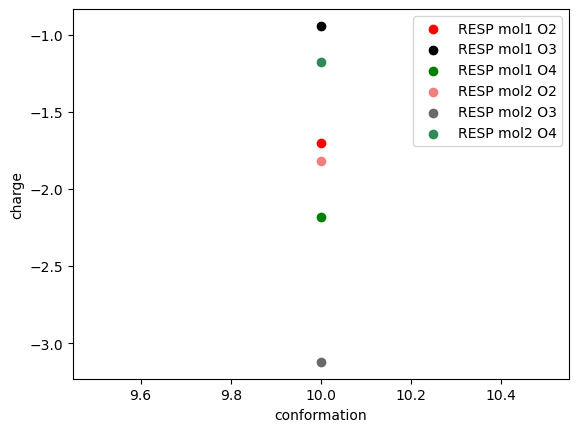

In [164]:
#plt.scatter(np.arange(0,50,1),Molsys.qm_charges['all'].T[np.r_[1,3:6]][0], label='RESP mol1 O1', color='blue')
plt.scatter(np.arange(0,50,1)[i],Molsys.qm_charges['all'].T[np.r_[1,3:6]][1][i], label='RESP mol1 O2', color='red')
plt.scatter(np.arange(0,50,1)[i],Molsys.qm_charges['all'].T[np.r_[1,3:6]][2][i], label='RESP mol1 O3', color='black')
plt.scatter(np.arange(0,50,1)[i],Molsys.qm_charges['all'].T[np.r_[1,3:6]][3][i], label='RESP mol1 O4', color='green')
#plt.scatter(np.arange(0,50,1),Molsys.qm_charges['all'].T[np.r_[12,14:17]][0], label='RESP mol2 O1', color='deepskyblue')
plt.scatter(np.arange(0,50,1)[i],Molsys.qm_charges['all'].T[np.r_[12,14:17]][1][i], label='RESP mol2 O2', color='lightcoral')
plt.scatter(np.arange(0,50,1)[i],Molsys.qm_charges['all'].T[np.r_[12,14:17]][2][i], label='RESP mol2 O3', color='dimgrey')
plt.scatter(np.arange(0,50,1)[i],Molsys.qm_charges['all'].T[np.r_[12,14:17]][3][i], label='RESP mol2 O4', color='seagreen')
#plt.axhline(y=Molsys.mm_charges['all'][np.r_[1,3:6]][0], color='blue', label='MM mol1 O1')
#plt.axhline(y=Molsys.mm_charges['all'][np.r_[1,3:6]][1], color='red', label='MM mol1 O2')
#plt.axhline(y=Molsys.mm_charges['all'][np.r_[1,3:6]][2], color='black', label='MM mol1 O3')
#plt.axhline(y=Molsys.mm_charges['all'][np.r_[1,3:6]][3], color='green', label='MM mol1 O4')
#plt.axhline(y=np.median(Molsys.qm_charges['all'].T[np.r_[1,12]][0]), color='deepskyblue', label='RESP median O1')
#plt.axhline(y=np.median(Molsys.qm_charges['all'].T[np.r_[3,14]][0]), color='lightcoral', label='RESP median O2')
#plt.axhline(y=np.median(Molsys.qm_charges['all'].T[np.r_[4,15]][0]), color='dimgrey', label='RESP median O3')
#plt.axhline(y=np.median(Molsys.qm_charges['all'].T[np.r_[5,16]][0]), color='seagreen', label='RESP median O4')

plt.legend()
plt.ylabel('charge')
plt.xlabel('conformation')

Text(0.5, 0, 'conformation')

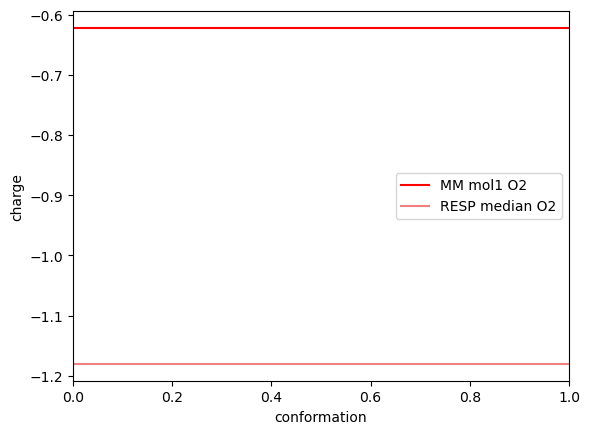

In [54]:
#plt.axhline(y=Molsys.mm_charges['all'][np.r_[1,3:6]][0], color='blue', label='MM mol1 O1')
plt.axhline(y=Molsys.mm_charges['all'][np.r_[1,3:6]][1], color='red', label='MM mol1 O2')
#plt.axhline(y=Molsys.mm_charges['all'][np.r_[1,3:6]][2], color='black', label='MM mol1 O3')
#plt.axhline(y=Molsys.mm_charges['all'][np.r_[1,3:6]][3], color='green', label='MM mol1 O4')
#plt.axhline(y=np.median(Molsys.qm_charges['all'].T[np.r_[1,12]][0]), color='deepskyblue', label='RESP median O1')
plt.axhline(y=np.median(Molsys.qm_charges['all'].T[np.r_[3,14]][0]), color='lightcoral', label='RESP median O2')
#plt.axhline(y=np.median(Molsys.qm_charges['all'].T[np.r_[4,15]][0]), color='dimgrey', label='RESP median O3')
#plt.axhline(y=np.median(Molsys.qm_charges['all'].T[np.r_[5,16]][0]), color='seagreen', label='RESP median O4')

plt.legend()
plt.ylabel('charge')
plt.xlabel('conformation')

Text(0.5, 0, 'conformation')

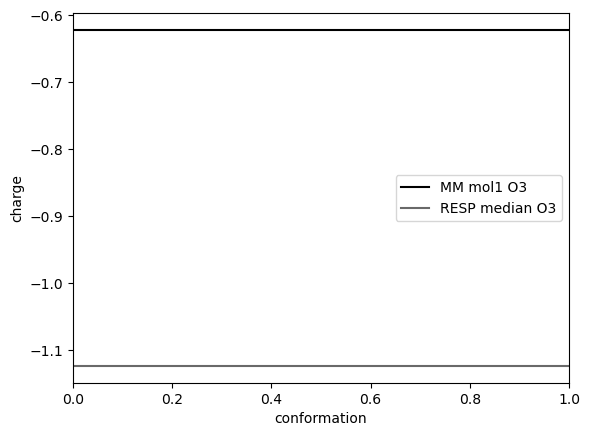

In [55]:
#plt.axhline(y=Molsys.mm_charges['all'][np.r_[1,3:6]][0], color='blue', label='MM mol1 O1')
#plt.axhline(y=Molsys.mm_charges['all'][np.r_[1,3:6]][1], color='red', label='MM mol1 O2')
plt.axhline(y=Molsys.mm_charges['all'][np.r_[1,3:6]][2], color='black', label='MM mol1 O3')
#plt.axhline(y=Molsys.mm_charges['all'][np.r_[1,3:6]][3], color='green', label='MM mol1 O4')
#plt.axhline(y=np.median(Molsys.qm_charges['all'].T[np.r_[1,12]][0]), color='deepskyblue', label='RESP median O1')
#plt.axhline(y=np.median(Molsys.qm_charges['all'].T[np.r_[3,14]][0]), color='lightcoral', label='RESP median O2')
plt.axhline(y=np.median(Molsys.qm_charges['all'].T[np.r_[4,15]][0]), color='dimgrey', label='RESP median O3')
#plt.axhline(y=np.median(Molsys.qm_charges['all'].T[np.r_[5,16]][0]), color='seagreen', label='RESP median O4')

plt.legend()
plt.ylabel('charge')
plt.xlabel('conformation')

Text(0.5, 0, 'conformation')

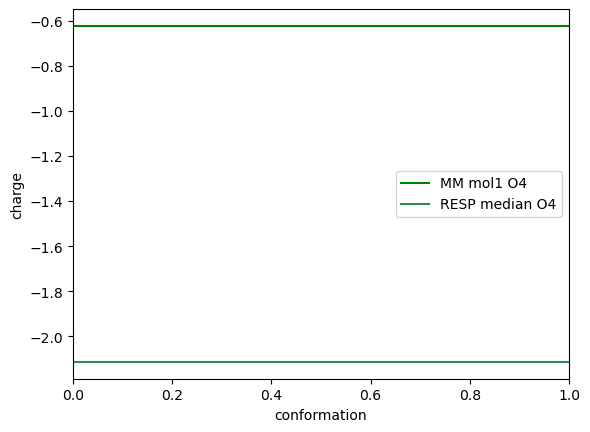

In [56]:
#plt.axhline(y=Molsys.mm_charges['all'][np.r_[1,3:6]][0], color='blue', label='MM mol1 O1')
#plt.axhline(y=Molsys.mm_charges['all'][np.r_[1,3:6]][1], color='red', label='MM mol1 O2')
#plt.axhline(y=Molsys.mm_charges['all'][np.r_[1,3:6]][2], color='black', label='MM mol1 O3')
plt.axhline(y=Molsys.mm_charges['all'][np.r_[1,3:6]][3], color='green', label='MM mol1 O4')
#plt.axhline(y=np.median(Molsys.qm_charges['all'].T[np.r_[1,12]][0]), color='deepskyblue', label='RESP median O1')
#plt.axhline(y=np.median(Molsys.qm_charges['all'].T[np.r_[3,14]][0]), color='lightcoral', label='RESP median O2')
#plt.axhline(y=np.median(Molsys.qm_charges['all'].T[np.r_[4,15]][0]), color='dimgrey', label='RESP median O3')
plt.axhline(y=np.median(Molsys.qm_charges['all'].T[np.r_[5,16]][0]), color='seagreen', label='RESP median O4')

plt.legend()
plt.ylabel('charge')
plt.xlabel('conformation')